# Load Data

In [1]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pickle
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
res_file = r"080124B_results.mat"
f = h5py.File(res_file)

for cell in f['results']['NaturalMovingObject'][1,:]:

    if len(f[cell]) < 63:
        continue

    trajx_n = []    
    trajy_n = []    
    trajx_c = []    
    trajy_c = []    
    spike_indices_n = []
    spike_indices_c = []
    
    for cx,cy,si,t in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['motion_trajectory'][0,:]):
        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'natural':
            trajx_n.extend(f[cx][:])
            trajy_n.extend(f[cy][:])
            spike_indices_n.append(f[si][:])
        else:
            trajx_c.extend(f[cx][:])
            trajy_c.extend(f[cy][:])
            spike_indices_c.append(f[si][:])
    break # only use the first cell, for this example

for cell in f['results']['SpotField'][1,:]:
    trajx_SF30 = []    
    trajy_SF30 = []    
    spike_indices_SF30 = [] 
    trajx_SF15 = []    
    trajy_SF15 = []
    spike_indices_SF15 = []

    for cx,cy,si,ss in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['spot_size'][0,:]):
        if f[ss][()]==30:
            trajx_SF30.extend(f[cx][:].transpose()+15)
            trajy_SF30.extend(f[cy][:].transpose()-25)
            spike_indices_SF30.append(f[si][:])
        else:
            trajx_SF15.extend(f[cx][:].transpose()+15)
            trajy_SF15.extend(f[cy][:].transpose()-25)
            spike_indices_SF15.append(f[si][:])
    break # only use the first cell

for cell in f['results']['SpotField'][1,:]:
    trajx_SF30 = []    
    trajy_SF30 = []    
    spike_indices_SF30 = [] 
    trajx_SF15 = []    
    trajy_SF15 = []
    spike_indices_SF15 = []

    for cx,cy,si,ss in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['spot_size'][0,:]):
        if f[ss][()]==30:
            trajx_SF30.extend(f[cx][:].transpose()+15)
            trajy_SF30.extend(f[cy][:].transpose()-25)
            spike_indices_SF30.append(f[si][:])
            
        else:
            trajx_SF15.extend(f[cx][:].transpose()+15)
            trajy_SF15.extend(f[cy][:].transpose()-25)
            spike_indices_SF15.append(f[si][:])
    break # only use the first cell



epochD = (15+15+45)/60 *10000# 1/10000 s
binsSF = np.arange(0, epochD*29, epochD) 
spikecountsSF15 = []
spikecountsSF30 = []
for i in range(len(spike_indices_SF30)):
    countstem, bin_edgesSF = np.histogram(spike_indices_SF30[i], bins=binsSF)
    spikecountsSF30.append(countstem)
for i in range(len(spike_indices_SF15)):
    countstem, bin_edgesSF = np.histogram(spike_indices_SF15[i], bins=binsSF)
    spikecountsSF15.append(countstem)

spikes=[]


trajx_n = np.asarray(trajx_n)
trajy_n = np.asarray(trajy_n)

trajx_c = np.asarray(trajx_c)
trajy_c = np.asarray(trajy_c)



# Stimuli generation

In [2]:
import stimgenerate as sg
stimuli_SF15 = []
stimuli_SF30 = []
for moving_trialidx in range(len(spike_indices_SF15)):
    stimuli_SF15.append(sg.generate_stimuli(trajx_SF15[moving_trialidx], trajy_SF15[moving_trialidx],board_size=400, diameter=15,fps = 60,pretime = 500,tailtime =500,type='spotfield',preframes=15,tailframes=45,stimframes=15)) 
for moving_trialidx in range(len(spike_indices_SF30)):
    stimuli_SF30.append(sg.generate_stimuli(trajx_SF30[moving_trialidx], trajy_SF30[moving_trialidx],board_size=400, diameter=30,fps = 60,pretime = 500,tailtime =500,type='spotfield',preframes=15,tailframes=45,stimframes=15))

# RF fitting via SpotField

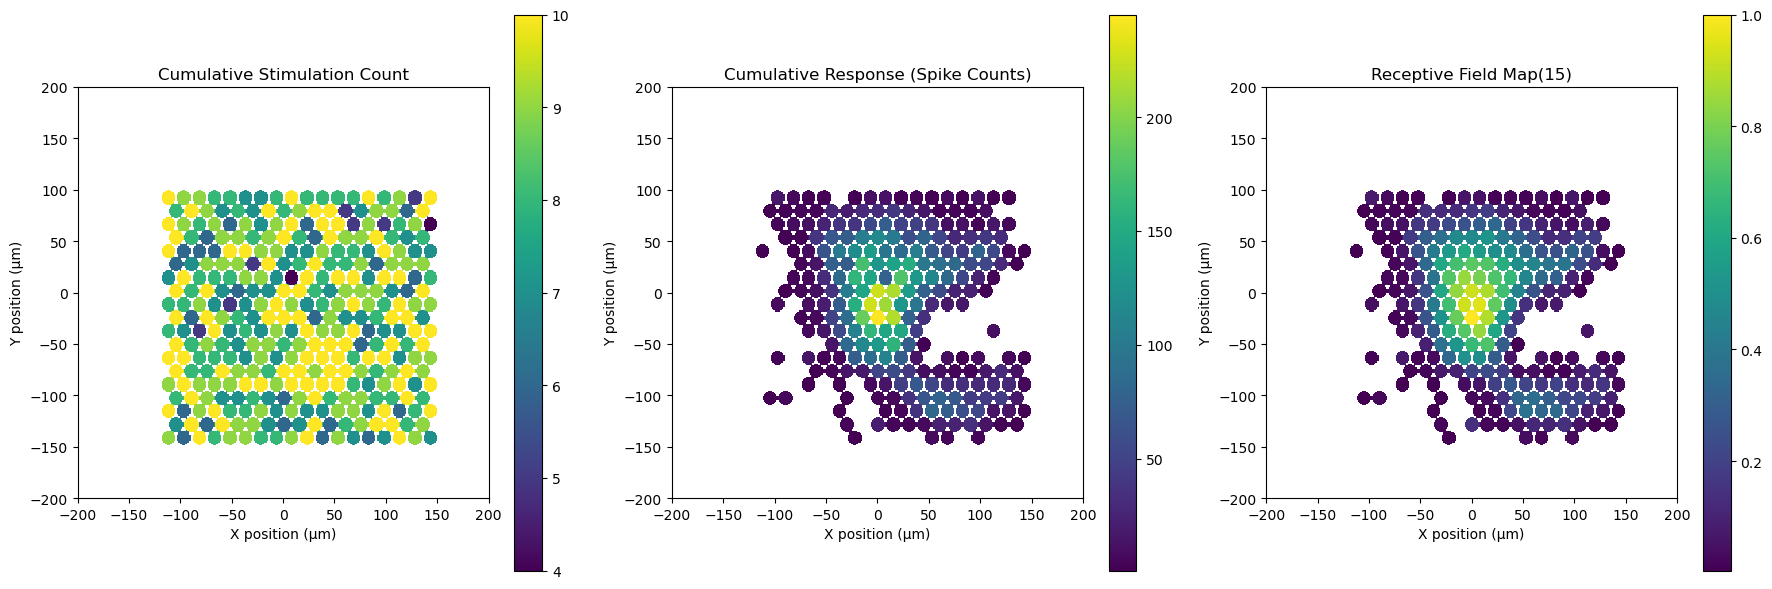

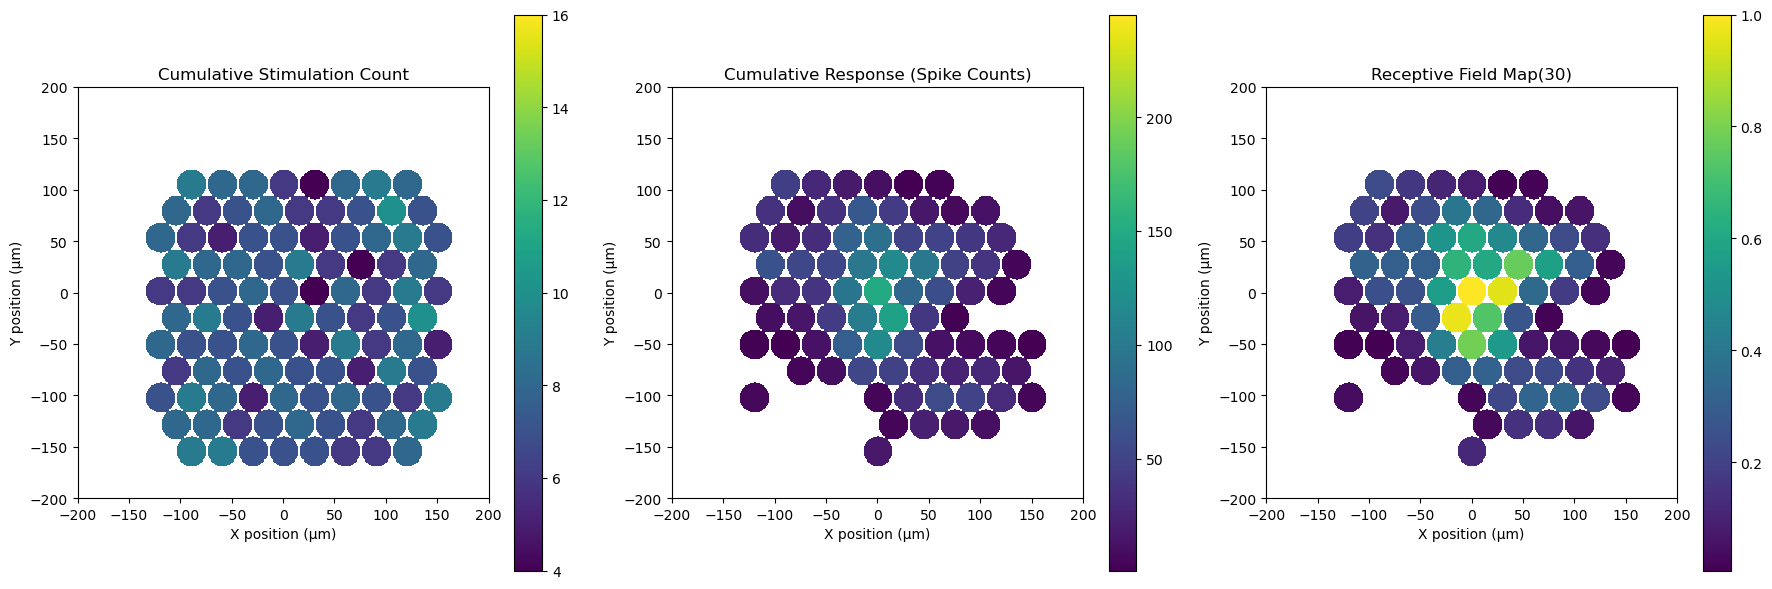

In [3]:
subepoch = 15 + 15 + 45  
board_shape = stimuli_SF15[0].shape[1:]  
extent = [-200, 200, -200, 200]

sum_response15 = np.zeros(board_shape, dtype=float)
sum_stim_count15 = np.zeros(board_shape, dtype=float)


for trial_stim, trial_spike_counts in zip(stimuli_SF15, spikecountsSF15):
    num_flashes = len(trial_spike_counts)
    for flash_idx in range(num_flashes):

        group_start = flash_idx * subepoch 
        stim_frame_idx = group_start + 16  
        mask = trial_stim[stim_frame_idx]
        count = trial_spike_counts[flash_idx]
        sum_response15 += mask * count
        sum_stim_count15 += mask


with np.errstate(divide='ignore', invalid='ignore'):
    rf15 = np.true_divide(sum_response15, sum_stim_count15)
    rf15[~np.isfinite(rf15)] = 0
rf15 = rf15 / np.max(rf15.flatten())
sum_response_plot15 = sum_response15.copy()
sum_response_plot15[sum_response_plot15 == 0] = np.nan
sum_stim_count_plot15 = sum_stim_count15.copy()
sum_stim_count_plot15[sum_stim_count_plot15 == 0] = np.nan
rf_plot15 = rf15.copy()
rf_plot15[rf_plot15 == 0] = np.nan


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(sum_stim_count_plot15, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count')
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')


im1 = axes[1].imshow(sum_response_plot15, extent=extent,origin='lower')
axes[1].set_title('Cumulative Response (Spike Counts)')
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

im2 = axes[2].imshow(rf_plot15, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map(15)')
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()

sum_response30 = np.zeros(board_shape, dtype=float)
sum_stim_count30 = np.zeros(board_shape, dtype=float)
for trial_stim, trial_spike_counts in zip(stimuli_SF30, spikecountsSF30):
    num_flashes = len(trial_spike_counts)
    for flash_idx in range(num_flashes):
        group_start = flash_idx * subepoch 
        stim_frame_idx = group_start + 16  
        mask = trial_stim[stim_frame_idx]
        count = trial_spike_counts[flash_idx]
        sum_response30 += mask * count
        sum_stim_count30 += mask
with np.errstate(divide='ignore', invalid='ignore'):
    rf30 = np.true_divide(sum_response30, sum_stim_count30)
    rf30[~np.isfinite(rf30)] = 0

rf30 = rf30 / np.max(rf30.flatten())
sum_response_plot30 = sum_response30.copy()
sum_response_plot30[sum_response_plot30 == 0] = np.nan
sum_stim_count_plot30 = sum_stim_count30.copy()
sum_stim_count_plot30[sum_stim_count_plot30 == 0] = np.nan
rf_plot30 = rf30.copy()
rf_plot30[rf_plot30 == 0] = np.nan

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
im0 = axes[0].imshow(sum_stim_count_plot30, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count')
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')
im1 = axes[1].imshow(sum_response_plot30, extent=extent,origin='lower')
axes[1].set_title('Cumulative Response (Spike Counts)')
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')
im2 = axes[2].imshow(rf_plot30, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map(30)')
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()




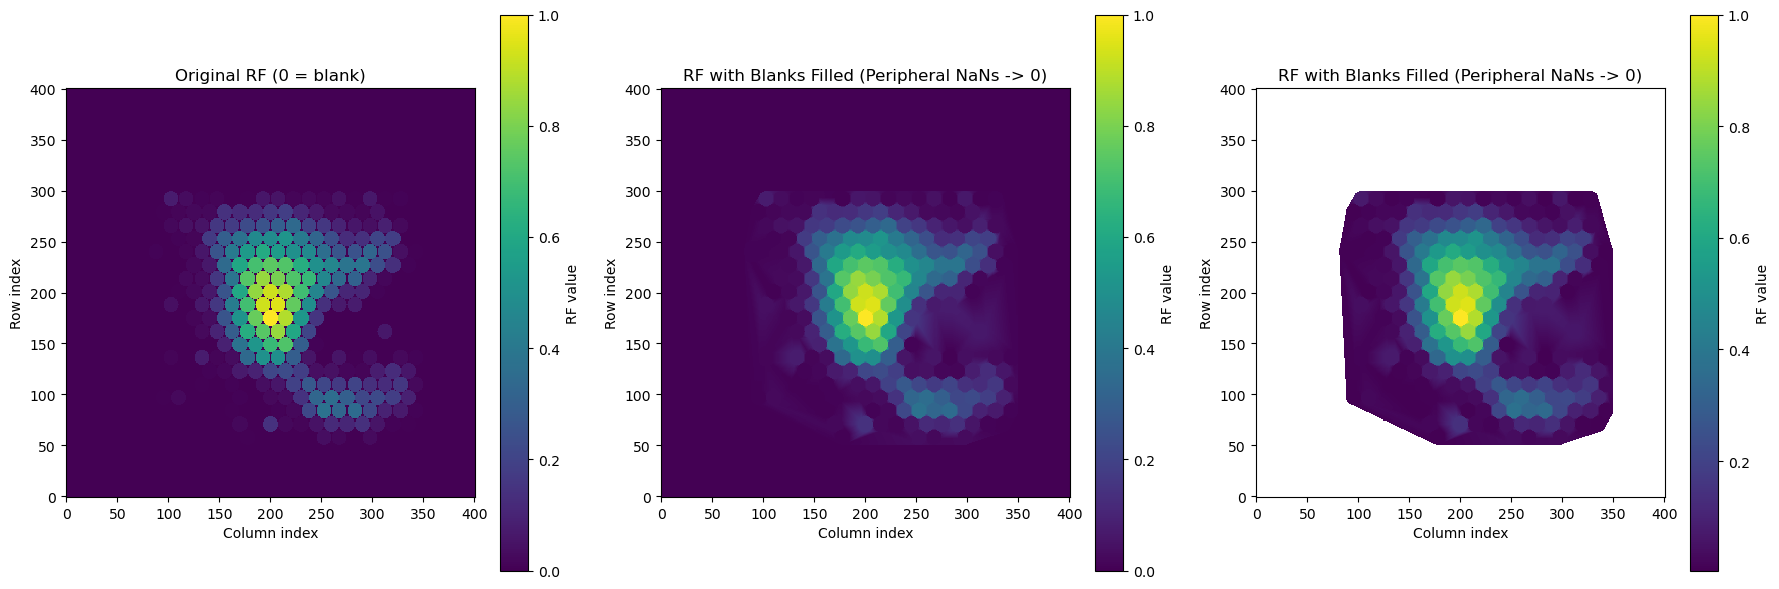

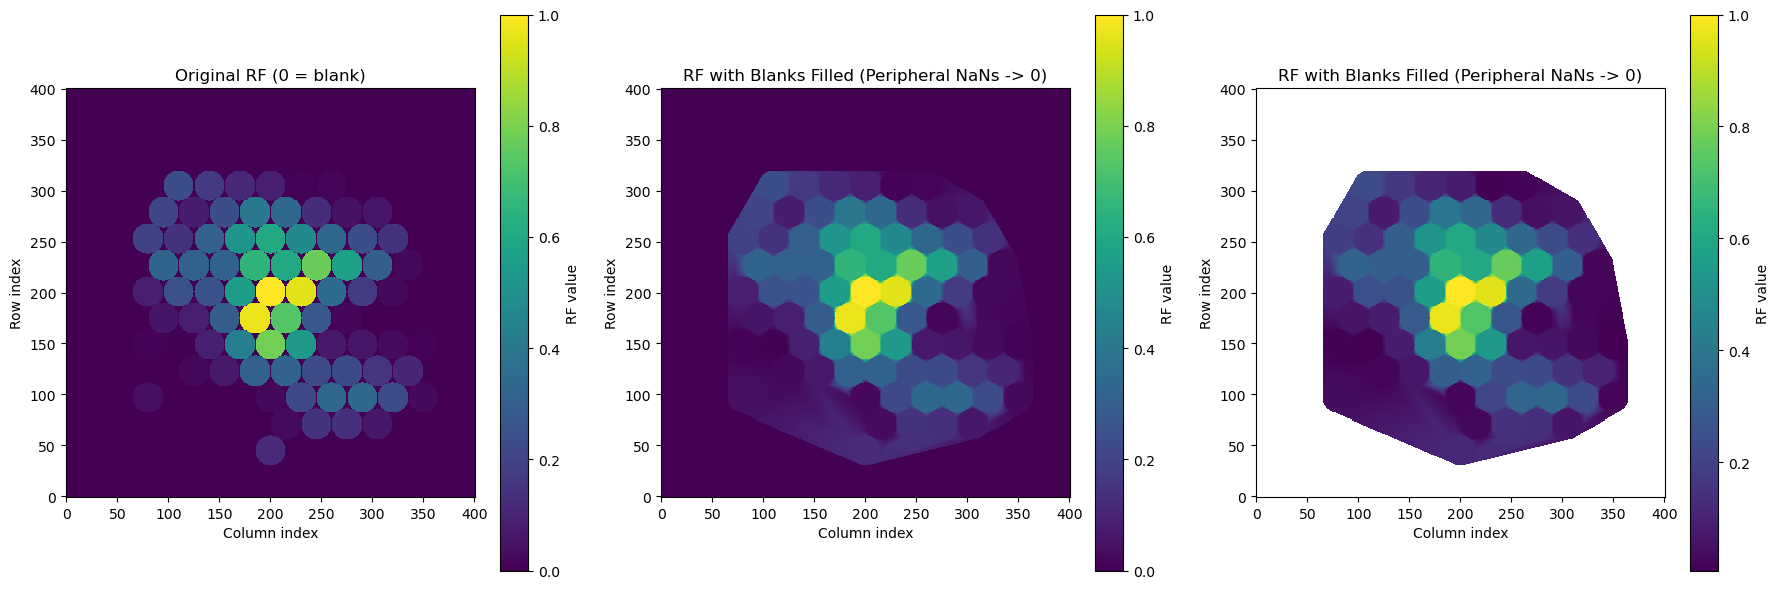

In [4]:
rows, cols = np.nonzero(rf15)
values = rf15[rows, cols]

grid_rows, grid_cols = np.mgrid[0:rf15.shape[0], 0:rf15.shape[1]]

rf_estimated15 = griddata(points=np.column_stack((rows, cols)),
                        values=values,
                        xi=(grid_rows, grid_cols),
                        method='linear')

rf_estimated15 = np.nan_to_num(rf_estimated15, nan=0)

rf_blank15 = rf_estimated15.copy()
blank_mask15 = (rf_estimated15 == 0)
rf_blank15[blank_mask15] = np.nan

# --- Visualize the results ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(rf15, origin='lower', cmap='viridis', interpolation='none')
plt.title('Original RF (0 = blank)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')

plt.subplot(1, 3, 2)
plt.imshow(rf_estimated15, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')

plt.subplot(1, 3, 3)
plt.imshow(rf_blank15, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')
plt.tight_layout()
plt.show()

rows, cols = np.nonzero(rf30)
values = rf30[rows, cols]

grid_rows, grid_cols = np.mgrid[0:rf30.shape[0], 0:rf30.shape[1]]

rf_estimated30 = griddata(points=np.column_stack((rows, cols)),
                        values=values,
                        xi=(grid_rows, grid_cols),
                        method='linear')

rf_estimated30 = np.nan_to_num(rf_estimated30, nan=0)

rf_blank30 = rf_estimated30.copy()
blank_mask30 = (rf_estimated30 == 0)
rf_blank30[blank_mask30] = np.nan

# --- Visualize the results ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(rf30, origin='lower', cmap='viridis', interpolation='none')
plt.title('Original RF (0 = blank)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')

plt.subplot(1, 3, 2)
plt.imshow(rf_estimated30, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')

plt.subplot(1, 3, 3)
plt.imshow(rf_blank30, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')
plt.tight_layout()
plt.show()

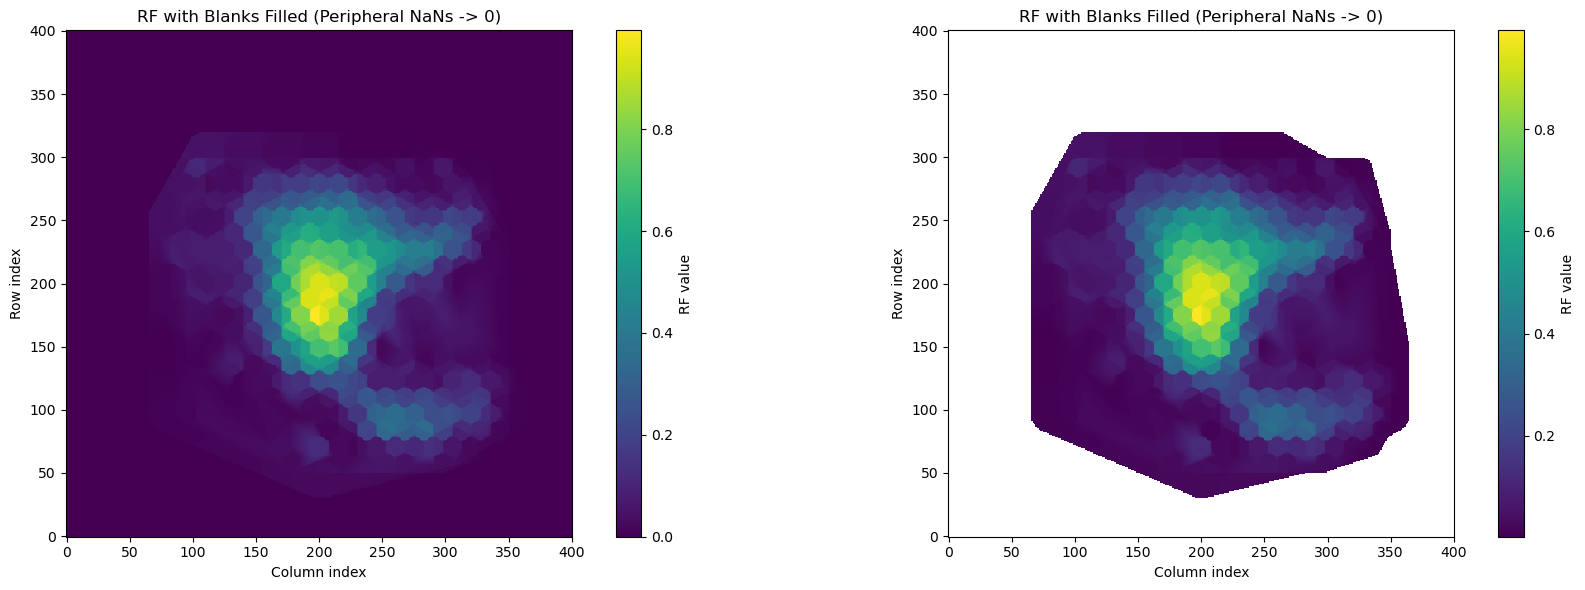

In [5]:

rf_estimatedC = rf_estimated15*100/126 + rf_estimated30*26/126 
rf_blankC = rf_estimatedC.copy()
blank_maskC = (rf_estimatedC == 0)
rf_blankC[blank_maskC] = np.nan

plt.figure(figsize=(18, 6))


plt.subplot(1, 2, 1)
plt.imshow(rf_estimatedC, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')

plt.subplot(1, 2, 2)
plt.imshow(rf_blankC, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.colorbar(label='RF value')
plt.tight_layout()
plt.show()

In [6]:
np.save('rf_estimated.npy', rf_estimatedC)

# Spatial Noise STA

In [7]:
def getMovie(attrs):
    
    noiseGen = np.random.RandomState(seed=int(attrs['noise_seed']))
    offsetGen = np.random.RandomState(seed=int(attrs['offset_seed']))
    
    nFrames = int(attrs['frame_rate'] * (attrs['pre_time'] + attrs['stim_time'] + attrs['tail_time']) / 1000)
    preFrames = int(attrs['frame_rate'] * attrs['pre_time'] / 1000)

    res = (int(attrs['resolution_y']), int(attrs['resolution_x']))
    subsample = (int(attrs['subsample_y']), int(attrs['subsample_x']))

    tmp = np.empty(res)
    mov = np.empty((nFrames, res[0]*subsample[0], res[1]*subsample[1]))

    ct = attrs['contrast_1'] * attrs['mean_level_1']

    if attrs['color_noise_distribution'] == 'binary':
        noiseFn = lambda x,y: 2 * (noiseGen.rand(x,y) > 0.5) - 1
    elif attrs['color_noise_distribution'] == 'gaussian':
        # noiseFn = lambda x,y: noiseGen.randn(x,y)
        raise 'Not yet implemented'
    elif attrs['color_noise_distribution'] == 'uniform':
        noiseFn = lambda x,y: 2 * noiseGen.rand(x,y) - 1

    for frame in np.arange(nFrames):
        if frame  - preFrames < 0:
            mov[frame] = np.clip(attrs['mean_level_1'], 0.0, 1.0)
        elif frame % attrs['frame_dwell']:
            mov[frame] = mov[frame - 1]
        else:
            tmp = np.clip(attrs['mean_level_1'] + ct * noiseFn(*res), 0.0, min(2*attrs['mean_level_1'], 1.0))
            
            p = (np.ceil(offsetGen.rand()*(2*attrs['subsample_x'] - 1) - attrs['subsample_x']).astype(int), -np.ceil(offsetGen.rand()*(2*attrs['subsample_y'] - 1) - attrs['subsample_y']).astype(int))

            mov[frame] = np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:])
            mov[frame] = np.roll(mov[frame], p[0], axis=0)
            mov[frame] = np.roll(mov[frame], p[1], axis=1)

            if p[0] >= 0:
                mov[frame,:p[0],:] = attrs['mean_level_1']
            else:
                mov[frame,p[0]:,:] = attrs['mean_level_1']
            
            if p[1] >= 0:
                mov[frame,:,:p[1]] = attrs['mean_level_1']
            else:
                mov[frame,:,p[1]:] = attrs['mean_level_1']
            
    return np.tile(mov[:,None, :, :], (1,attrs['subsample_t'], 1, 1)).reshape((-1, *mov.shape[1:]))


def dereference_reference(reference, file):

    if isinstance(reference, h5py.Reference):  
        obj = file[reference] 
        if isinstance(obj, h5py.Dataset):
            if obj.shape == ():  
                return float(obj[()]) if obj.dtype.kind in {'u'} else str(obj[()])
            elif 0 < len(obj.shape) : 
                if obj.dtype == np.dtype('uint32'):
                    return obj[:]
                
                elif obj.dtype.kind in {'u'} and obj.ndim == 2: 
                    return ''.join(chr(x[0]) for x in obj[:])  
                
                elif obj.dtype.kind in {'f'}:  
                    return float(obj[:])
                elif obj.dtype.kind in {'u'}:  
                    return obj[:]        
                else:
                    raise ValueError("Unsupported data type in dataset.")
            elif  len(obj.shape) > 15 :
                return obj[:]
        else:
            raise TypeError("The reference points to a non-dataset object.")
    else:
        raise TypeError("Provided object is not a valid h5py.Reference.")
    
    
    
def dereference_group(group, file):
    extracted_data = {}
    for key in group.keys():
        reference = group[key][0][1] 
        extracted_data[key] = dereference_reference(reference, file)
    return extracted_data

def dereference_group_iterative(group, file):
    extracted_data_all = {}
    for i in range(len(group[next(iter(group))][0])):  
        extracted_data = {}
        for key in group.keys():
            reference = group[key][0][i]  # Access the `i-th` element
            extracted_data[key] = dereference_reference(reference, file)
        extracted_data_all[f'{i}'] = extracted_data
    return extracted_data_all

def getMovie(attrs):
    attrs['subsample_t'] = 1
    noiseGen = np.random.RandomState(seed=int(attrs['noise_seed']))
    offsetGen = np.random.RandomState(seed=int(attrs['offset_seed']))

    nFrames = int(attrs['frame_rate'] * (attrs['pre_time'] + attrs['stim_time'] + attrs['tail_time']) / 1000)
    preFrames = int(attrs['frame_rate'] * attrs['pre_time'] / 1000)

    res = (int(attrs['resolution_y']), int(attrs['resolution_x']))
    subsample = (int(attrs['subsample_y']), int(attrs['subsample_x']))

    tmp = np.empty(res)
    mov = np.empty((nFrames, res[0]*subsample[0], res[1]*subsample[1]))

    ct = attrs['contrast_1'] * attrs['mean_level_1']

    if attrs['color_noise_distribution'] == 'binary':
        noiseFn = lambda x,y: 2 * (noiseGen.rand(x,y) > 0.5) - 1
    elif attrs['color_noise_distribution'] == 'gaussian':
        # noiseFn = lambda x,y: noiseGen.randn(x,y)
        raise 'Not yet implemented'
    elif attrs['color_noise_distribution'] == 'uniform':
        noiseFn = lambda x,y: 2 * noiseGen.rand(x,y) - 1

    for frame in np.arange(nFrames):
        if frame  - preFrames < 0:
            mov[frame] = np.clip(attrs['mean_level_1'], 0.0, 1.0)
        elif frame % attrs['frame_dwell']:
            mov[frame] = mov[frame - 1]
        else:
            tmp = np.clip(attrs['mean_level_1'] + ct * noiseFn(*res), 0.0, min(2*attrs['mean_level_1'], 1.0))
            p = (np.ceil(offsetGen.rand()*(2*attrs['subsample_x'] - 1) - attrs['subsample_x']).astype(int), -np.ceil(offsetGen.rand()*(2*attrs['subsample_y'] - 1) - attrs['subsample_y']).astype(int))
            mov[frame] = np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:])
            mov[frame] = np.roll(mov[frame], p[0], axis=0)
            mov[frame] = np.roll(mov[frame], p[1], axis=1)

            if p[0] >= 0:
                mov[frame,:p[0],:] = attrs['mean_level_1']
            else:
                mov[frame,p[0]:,:] = attrs['mean_level_1']
            
            if p[1] >= 0:
                mov[frame,:,:p[1]] = attrs['mean_level_1']
            else:
                mov[frame,:,p[1]:] = attrs['mean_level_1']

    return np.tile(mov[:,None, :, :], (1,attrs['subsample_t'], 1, 1)).reshape((-1, *mov.shape[1:]))

with h5py.File("080124B_results.mat", 'r') as f:
    spatial_noise_group = f[f['results']['SpatialNoise'][1,0]]  
    dereferenced_data = dereference_group(spatial_noise_group, f)
    
    
with h5py.File("080124B_results.mat", 'r') as f:
    spatial_noise_group = f[f['results']['SpatialNoise'][1,0]] 
    deref_dic = dereference_group_iterative(spatial_noise_group, f)


C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_30172\3686631141.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(obj[:])


In [8]:
T = 40 # 1/60 *50 = 0.83 sec
Y,X = 16,16
sta_sn_noshift2 = np.zeros((T, Y, X))
sta_sn_noshift5 = np.zeros((T, 24, 24))

d = np.zeros(T)
c = np.zeros(T)

for i in iter(deref_dic):
    if deref_dic[str(i)]['frame_dwell'] != 2:
        sta = sta_sn_noshift5
        cnt = d

    else:
        sta = sta_sn_noshift2
        cnt = c

    
    spike_train = deref_dic[str(i)]['spike_indices'].flatten()
    spike_indices = (spike_train / deref_dic[f'{i}']['sample_rate'] * deref_dic[str(i)]['frame_rate']).astype(int)
    mov = getMovie(deref_dic[str(i)])
    n_frames = mov.shape[0]


        
    for si in spike_indices:
        i0 = si - T 
        sta[max(-i0,0):] += mov[max(i0,0):si]
        cnt[max(-i0,0):] += 1

        

avg_sta_sn_noshift2 = sta_sn_noshift2 / d[:,None,None]
avg_sta_sn_noshift5 = sta_sn_noshift5 / c[:,None,None]


(40, 1) (16, 16)
35


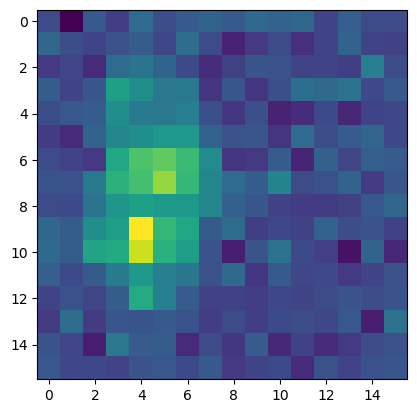

<Figure size 640x480 with 0 Axes>

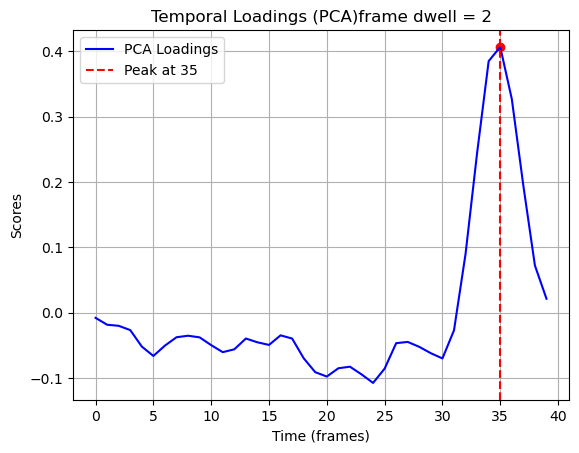

In [9]:

from sklearn.decomposition import PCA

mod = PCA(1)

loadings = mod.fit_transform(avg_sta_sn_noshift2.reshape(T,Y*X))
components = mod.components_.reshape(Y,X)
std = np.sqrt(mod.explained_variance_)  
print(loadings.shape, components.shape)

plt.imshow(components)

plt.figure()
peak_idx2 = np.argmax(loadings)  
peak_value2 = loadings[peak_idx2]  
print(peak_idx2)
plt.figure()
plt.plot(loadings, label='PCA Loadings', color='blue')
plt.axvline(peak_idx2, color='red', linestyle='--', label=f'Peak at {peak_idx2}')
plt.scatter(peak_idx2, peak_value2, color='red')  
plt.xlabel('Time (frames)')
plt.ylabel('Scores')
plt.title('Temporal Loadings (PCA)frame dwell = 2')
plt.legend()
plt.grid(True)
plt.show()

(40, 1) (24, 24)
35


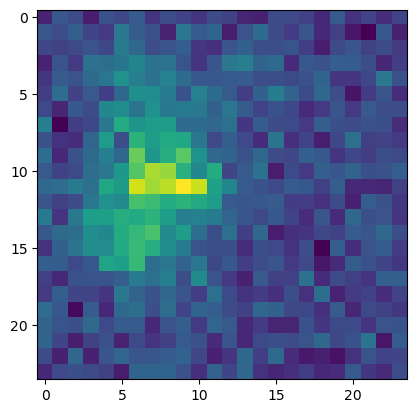

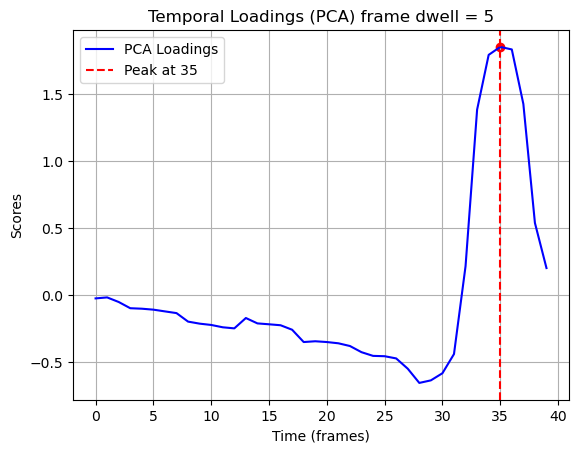

In [10]:

mod = PCA(1)
loadings = mod.fit_transform(avg_sta_sn_noshift5.reshape(T,24*24))
components = mod.components_.reshape(24,24)
std = np.sqrt(mod.explained_variance_)  
print(loadings.shape, components.shape)

plt.imshow(components)


peak_idx5 = np.argmax(loadings)  
peak_value5 = loadings[peak_idx5] 
print(peak_idx5) 
plt.figure()
plt.plot(loadings, label='PCA Loadings', color='blue')

plt.axvline(peak_idx5, color='red', linestyle='--', label=f'Peak at {peak_idx5}')
plt.scatter(peak_idx5, peak_value5, color='red')  
plt.xlabel('Time (frames)')
plt.ylabel('Scores')
plt.title('Temporal Loadings (PCA) frame dwell = 5')
plt.legend()
plt.grid(True)
plt.show()


# 83 ms



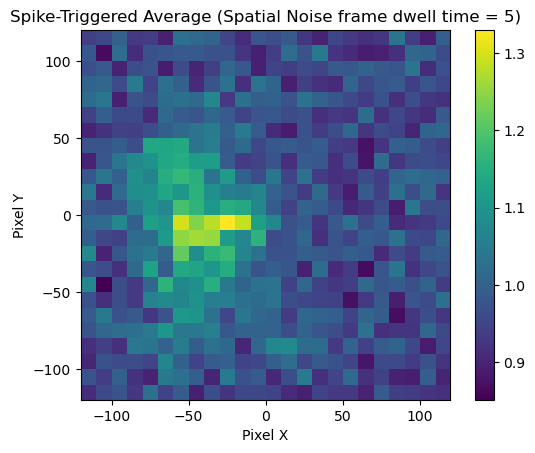

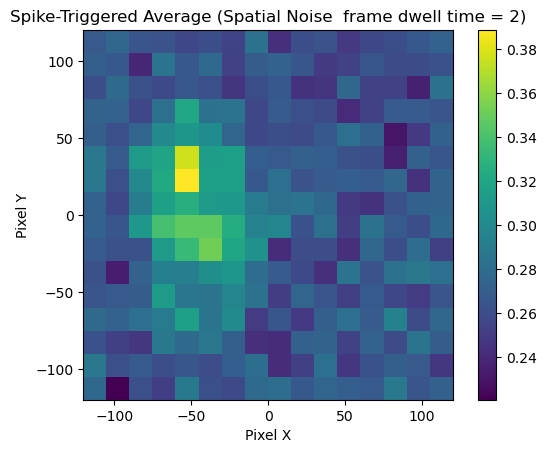

In [11]:
extent = [-120, 120, -120, 120]
plt.imshow(avg_sta_sn_noshift5[peak_idx5],extent=extent,origin='lower')
plt.colorbar() 
plt.title("Spike-Triggered Average (Spatial Noise frame dwell time = 5)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

plt.imshow(avg_sta_sn_noshift2[peak_idx2],extent=extent,origin='lower')
plt.colorbar() 
plt.title("Spike-Triggered Average (Spatial Noise  frame dwell time = 2)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [12]:
from scipy.ndimage import zoom

In [13]:
sta_sn_noshift5upscaled = zoom(avg_sta_sn_noshift5, zoom=(1, 10.04, 10.04), order=0)
sta_sn_noshift2upscaled = zoom(avg_sta_sn_noshift2, zoom=(1, 241/16, 241/16), order=0)

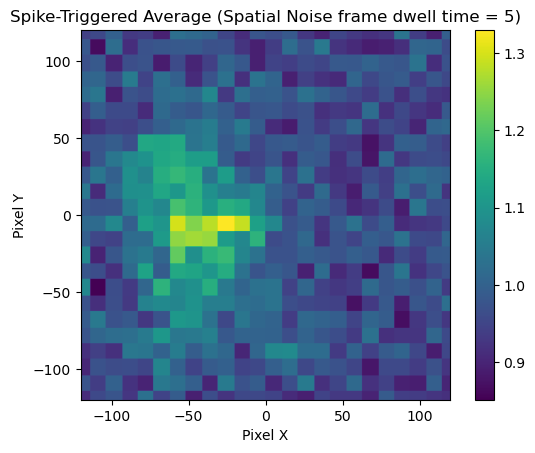

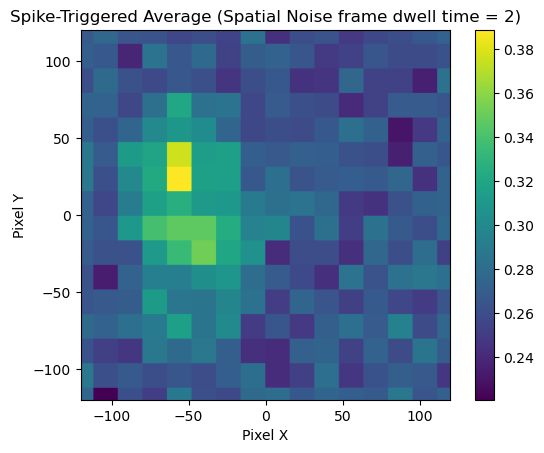

In [14]:
plt.imshow(sta_sn_noshift5upscaled[peak_idx5],extent=extent,origin='lower')
plt.colorbar() 
plt.title("Spike-Triggered Average (Spatial Noise frame dwell time = 5)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

plt.imshow(sta_sn_noshift2upscaled[peak_idx5],extent=extent,origin='lower')
plt.colorbar() 
plt.title("Spike-Triggered Average (Spatial Noise frame dwell time = 2)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [15]:
rf_estimated = np.load('rf_estimated.npy')

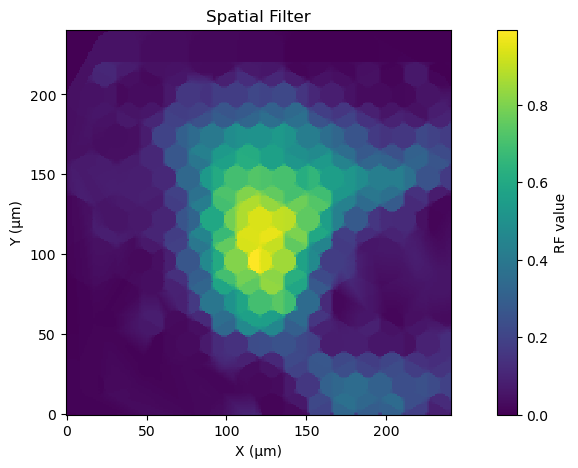

In [16]:
plt.figure(figsize=(12, 5))
plt.imshow(rf_estimated[79:320,79:320], origin='lower', cmap='viridis', interpolation='none')
plt.title('Spatial Filter')
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.colorbar(label='RF value')



In [17]:
n_time = sta_sn_noshift5upscaled.shape[0]
temporal_filter5 = np.empty(n_time)
temporal_filter2 = np.empty(n_time)

for t in range(n_time):
    temporal_filter5[t] = np.sum(rf_estimated[79:320,79:320] * sta_sn_noshift5upscaled[t, :, :])
    temporal_filter2[t] = np.sum(rf_estimated[79:320,79:320] * sta_sn_noshift2upscaled[t, :, :])

temfilter5 = (temporal_filter5-temporal_filter5[-1])/max(temporal_filter5-temporal_filter5[-1])
temfilter2 = (temporal_filter2-temporal_filter2[-1])/max(temporal_filter2-temporal_filter2[-1])

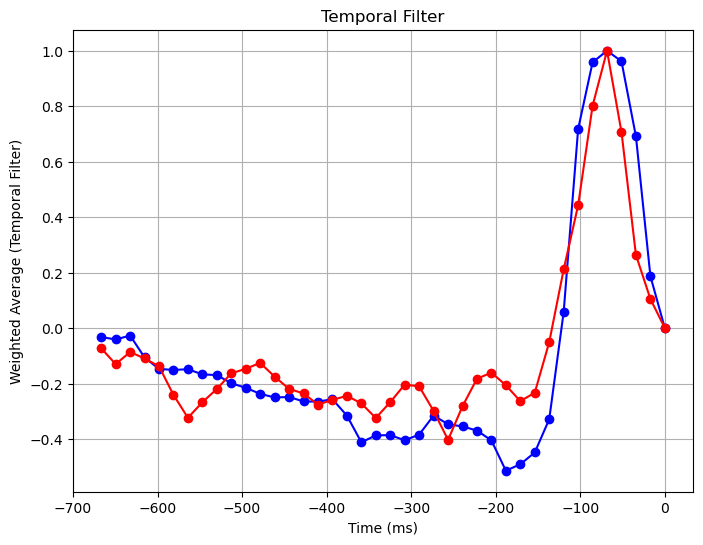

In [18]:
t = np.linspace(-T*50/3, 0, T) 
plt.figure(figsize=(8, 6))
plt.plot(t,temfilter5, marker='o', linestyle='-', color='b')
plt.plot(t,temfilter2, marker='o', linestyle='-', color='r')
plt.xlabel('Time (ms)')
plt.ylabel('Weighted Average (Temporal Filter)')
plt.title('Temporal Filter')
plt.grid(True)
plt.show()

In [19]:
np.save('temporal_filter5.npy', temfilter5)
np.save('temporal_filter2.npy', temfilter2)